In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
titanic = pd.read_csv("data/train.csv")

In [3]:
titanic.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
652,653,0,3,"Kalvik, Mr. Johannes Halvorsen",male,21.0,0,0,8475,8.4333,NaN,S
92,93,0,1,"Chaffee, Mr. Herbert Fuller",male,46.0,1,0,W.E.P. 5734,61.1750,E31,S
731,732,0,3,"Hassan, Mr. Houssein G N",male,11.0,0,0,2699,18.7875,NaN,C
549,550,1,2,"Davies, Master. John Morgan Jr",male,8.0,1,1,C.A. 33112,36.7500,NaN,S
504,505,1,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.5000,B79,S


# PipeLines

In [4]:
from sklego.pandas_utils import log_step
import logging
#logging.basicConfig(level=logging.DEBUG)

In [5]:
@log_step
def start_pipeline(dataframe):
    return dataframe.copy()

@log_step
def set_dtypes(dataframe):
    dataframe["Sex"]=dataframe["Sex"].astype("category")
    dataframe["Embarked"]=dataframe["Embarked"].astype("category")
    return dataframe

@log_step
def missing_values(dataframe):
    dataframe['Age']=dataframe['Age'].fillna(titanic.groupby('Pclass')['Age'].transform('mean'))
    dataframe["Embarked"]=dataframe["Embarked"].fillna('C')
    return dataframe

normalized_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"
}

@log_step
def new_features(dataframe):
    dataframe['Total_family']=dataframe['SibSp']+dataframe['Parch']
    dataframe["Alone"]=dataframe["Total_family"].apply(lambda x:0 if x>0 else 1)
    dataframe["Title"]=dataframe["Name"].apply(lambda name: name.split(',')[1].split('.')[0].strip())
    dataframe["Title_group"]=dataframe["Title"].map(normalized_titles)
    return dataframe

@log_step
def binnary(dataframe):
    dataframe["Sex"]=dataframe["Sex"].cat.codes
    dataframe["Embarked"]=dataframe["Embarked"].cat.codes
    return dataframe

@log_step
def drop_columns(dataframe):
    return dataframe.drop(columns=["PassengerId","Cabin","Ticket","Title","Name"])

@log_step
def drop_duplicates(dataframe):
    return dataframe.drop_duplicates()

In [6]:
titanic_clean=titanic.pipe(start_pipeline)\
                     .pipe(set_dtypes)\
                     .pipe(missing_values)\
                     .pipe(new_features)\
                     .pipe(drop_columns)\
                     .pipe(binnary)\
                     .pipe(drop_duplicates)

[start_pipeline(df)] time=0:00:00.000997 n_obs=891, n_col=12
[set_dtypes(df)] time=0:00:00.004005 n_obs=891, n_col=12
[missing_values(df)] time=0:00:00.004993 n_obs=891, n_col=12
[new_features(df)] time=0:00:00.007000 n_obs=891, n_col=16
[drop_columns(df)] time=0:00:00.002000 n_obs=891, n_col=11
[binnary(df)] time=0:00:00.000999 n_obs=891, n_col=11
[drop_duplicates(df)] time=0:00:00.004002 n_obs=787, n_col=11


In [7]:
titanic_clean.pivot_table(columns=["Pclass"],
                          index=["Sex"],
                          values="Survived",
                          aggfunc="mean",
                          margins=True
                         )

Pclass,1,2,3,All
Sex,,,,
0,0.968085,0.918919,0.472868,0.740741
1,0.378151,0.182796,0.158273,0.216327
All,0.638498,0.508982,0.257985,0.414231


In [8]:
titanic_clean.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Total_family,Alone,Title_group
0,0,3,1,22.0,1,0,7.2500,2,1,0,Mr
1,1,1,0,38.0,1,0,71.2833,0,1,0,Mrs
2,1,3,0,26.0,0,0,7.9250,2,0,1,Miss
3,1,1,0,35.0,1,0,53.1000,2,1,0,Mrs
4,0,3,1,35.0,0,0,8.0500,2,0,1,Mr


# Split Data

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = titanic_clean.drop(["Survived","Title_group"],axis=1)
y = titanic_clean["Survived"]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=X["Pclass"], test_size=0.33, random_state=42)

# Feature Selection

## Boruta

In [12]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

In [18]:
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5,random_state=42)

feat_selector_boruta = BorutaPy(rf, n_estimators=100, verbose=2, random_state=42)

In [19]:
feat_selector_boruta.fit(X_train.values, y_train.values.ravel())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	5


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	5


BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x1D77BA549D8),
         n_estimators=100, random_state=RandomState(MT19937) at 0x1D77BA549D8,
         verbose=2)

In [28]:
boruta_dict = {"Features":X_train.columns,
               "Ranking":feat_selector_boruta.ranking_,
               "Support":feat_selector_boruta.support_}

In [30]:
pd.DataFrame(boruta_dict).sort_values("Ranking")

,Features,Ranking,Support
0,Pclass,1,True
1,Sex,1,True
2,Age,1,True
5,Fare,1,True
7,Total_family,2,False
3,SibSp,3,False
6,Embarked,4,False
4,Parch,5,False
8,Alone,6,False


## BorutaShap

In [12]:
from BorutaShap import BorutaShap

In [13]:
Feature_Selector = BorutaShap(importance_measure='shap',classification=True)

In [14]:
Feature_Selector.fit(X=X,
                     y=y,
                     n_trials=20,
                     random_state=42,
                     sample=False,
                     #train_or_test = 'test',
                     #normalize=True,
                     verbose=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:03<00:00,  3.20s/it]

5 attributes confirmed important: ['Fare', 'Age', 'Sex', 'Pclass', 'Embarked']
3 attributes confirmed unimportant: ['SibSp', 'Parch', 'Alone']
1 tentative attributes remains: ['Total_family']


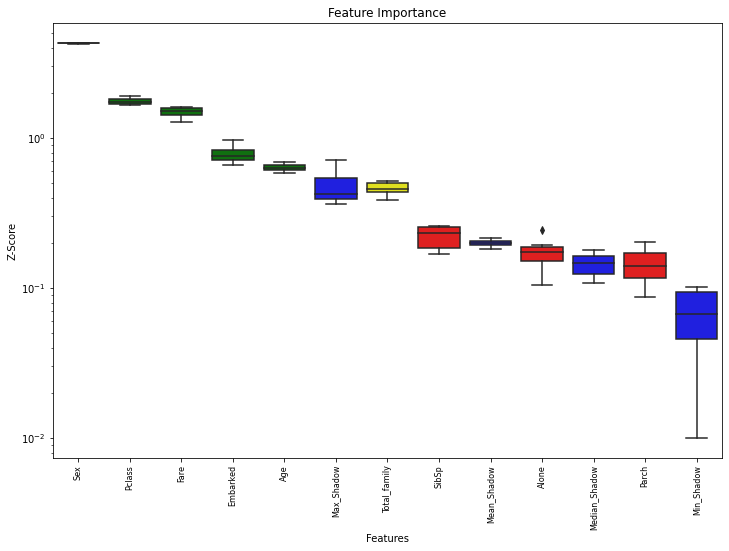

In [15]:
Feature_Selector.plot(which_features='all')

In [16]:
from xgboost import XGBClassifier
model = XGBClassifier(objective='binary:logistic',eval_metric="auc")

In [17]:
Feature_Selector = BorutaShap(model=model,
                              importance_measure='shap',
                              classification=True)

Feature_Selector.fit(X=X,
                     y=y,
                     n_trials=100,
                     sample=False,
                     #train_or_test = 'test',
                     normalize=True,
                     verbose=True)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.63it/s]

4 attributes confirmed important: ['Pclass', 'Fare', 'Sex', 'Age']
5 attributes confirmed unimportant: ['SibSp', 'Total_family', 'Parch', 'Alone', 'Embarked']
0 tentative attributes remains: []


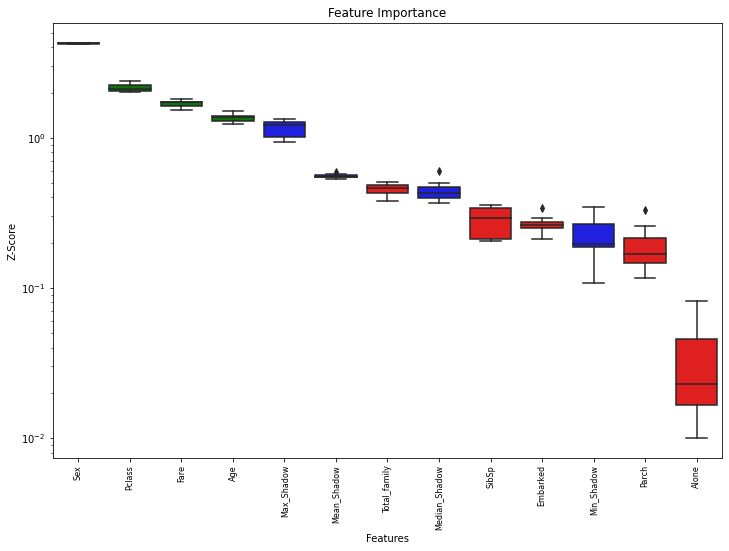

In [18]:
Feature_Selector.plot(which_features='all')

## ShapRFECV 

In [20]:
from probatus.feature_elimination import ShapRFECV
from probatus.interpret import ShapModelInterpreter
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [20]:
clf = RandomForestClassifier(max_depth=5, class_weight='balanced',random_state=42)

param_grid = {
    'n_estimators': [50, 75, 100,150],
    'min_samples_leaf': [3, 5, 7, 10],
}
search = RandomizedSearchCV(clf, param_grid)
shap_elimination = ShapRFECV(clf=search,min_features_to_select=1, step=0.2, cv=10, scoring='roc_auc', n_jobs=8)

In [21]:
%%time
report = shap_elimination.fit_compute(X, y)

Wall time: 1min 14s


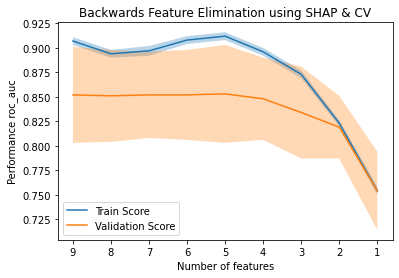

In [22]:
performance_plot = shap_elimination.plot()

In [23]:
report

,num_features,features_set,eliminated_features,train_metric_mean,train_metric_std,val_metric_mean,val_metric_std
1,9,"[Pclass, Sex, Age, SibSp, Parch, Fare, Embarke...",[Alone],0.907,0.004,0.852,0.049
2,8,"[Fare, SibSp, Age, Sex, Total_family, Parch, P...",[SibSp],0.894,0.004,0.851,0.047
3,7,"[Fare, Age, Total_family, Sex, Parch, Pclass, ...",[Parch],0.897,0.005,0.852,0.044
4,6,"[Fare, Age, Total_family, Sex, Pclass, Embarked]",[Embarked],0.908,0.004,0.852,0.046
5,5,"[Fare, Age, Total_family, Sex, Pclass]",[Total_family],0.912,0.004,0.853,0.050
6,4,"[Pclass, Fare, Sex, Age]",[Age],0.896,0.004,0.848,0.042
7,3,"[Pclass, Fare, Sex]",[Fare],0.873,0.004,0.834,0.047
8,2,"[Pclass, Sex]",[Pclass],0.823,0.003,0.819,0.032
9,1,[Sex],[],0.754,0.004,0.754,0.040


In [24]:
%%time
clf = RandomForestClassifier(class_weight='balanced', n_estimators = 150, max_depth=3, random_state=42)
clf.fit(X_train, y_train)

Wall time: 221 ms


RandomForestClassifier(class_weight='balanced', max_depth=3, n_estimators=150,
                       random_state=42)

In [25]:
%%time
# Train ShapModelInterpreter
shap_interpreter = ShapModelInterpreter(clf)
feature_importance = shap_interpreter.fit_compute(X_train, X_test, y_train, y_test)

Wall time: 189 ms


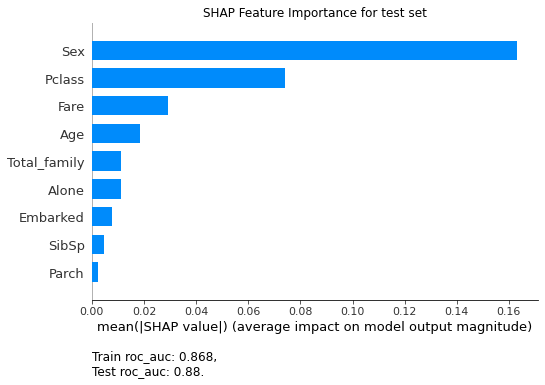

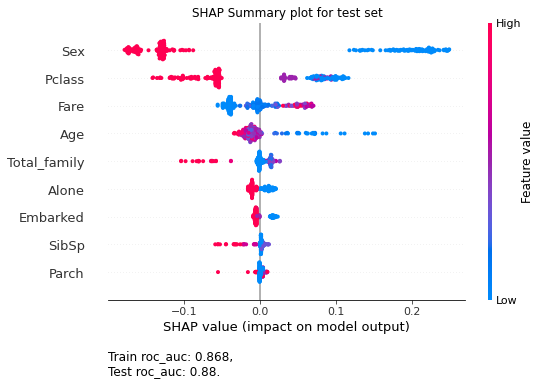

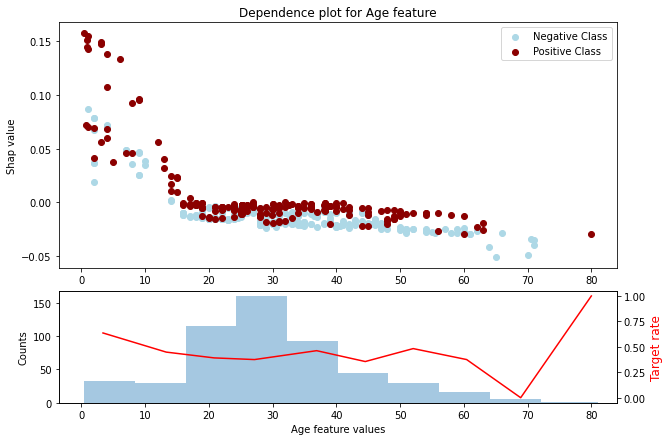

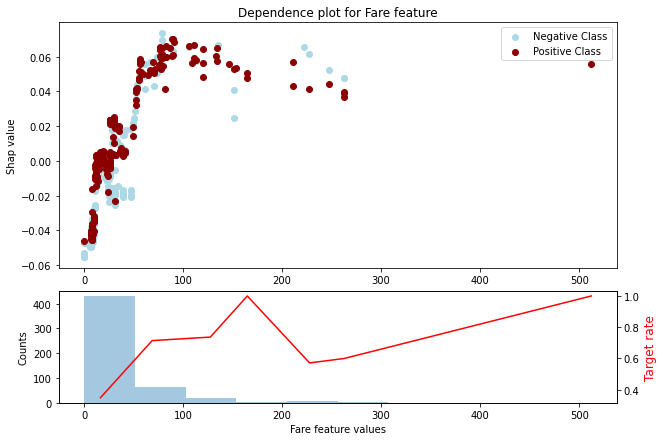

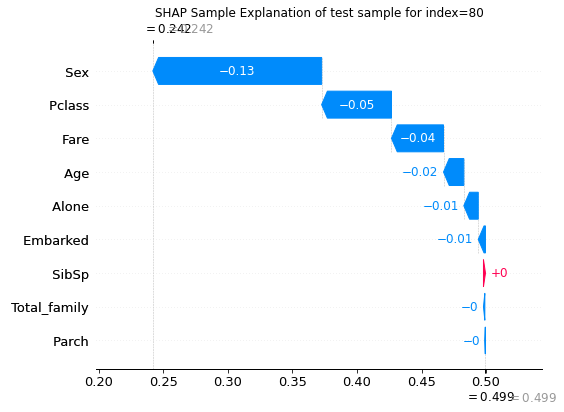

In [26]:
# Make plots
ax1 = shap_interpreter.plot('importance')
ax2 = shap_interpreter.plot('summary')
ax3 = shap_interpreter.plot('dependence', target_columns=['Age', 'Fare'])
ax4 = shap_interpreter.plot('sample', samples_index=[X_test.index.tolist()[0]])

In [27]:
from probatus.metric_volatility import BootstrappedVolatility

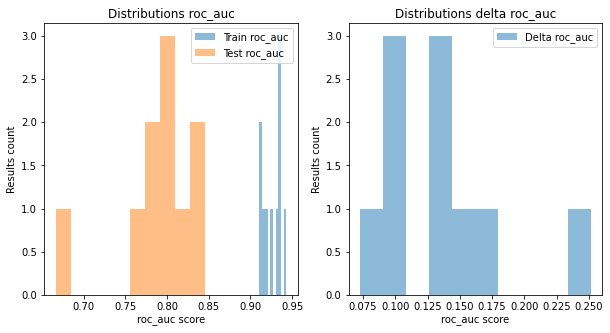

In [28]:
volatility = BootstrappedVolatility(clf, iterations=10 , test_prc = 0.5)
volatility_report = volatility.fit_compute(X_train, y_train)
volatility.plot();

## Partial Dependency Plots

In [25]:
from sklearn.inspection import partial_dependence, plot_partial_dependence

In [29]:
%%time
clf = RandomForestClassifier(class_weight='balanced', n_estimators = 150, max_depth=3, random_state=42)
clf.fit(X_train, y_train)

Wall time: 257 ms


RandomForestClassifier(class_weight='balanced', max_depth=3, n_estimators=150,
                       random_state=42)

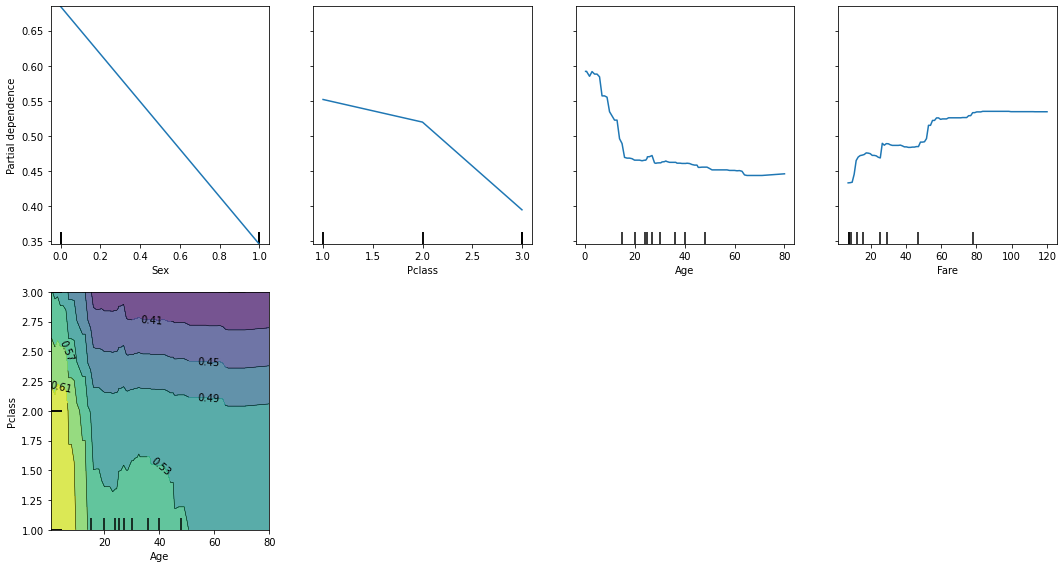

In [54]:
fig=plt.figure(figsize=(15, 8))
plot_partial_dependence(clf, X_train,
                        features=[1,0,2,5,(2,0)],
                        feature_names=X_train.columns,
                        target="Survival",
                        n_cols=4,
                        grid_resolution=100,
                        fig=fig
                       )
plt.tight_layout();

# AutoML

## TPOT

In [29]:
from tpot import TPOTClassifier

In [57]:
X = titanic_clean.drop(["Survived","Title_group"],axis=1)
y = titanic_clean["Survived"]

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=X["Pclass"], test_size=0.25, random_state=42)

In [59]:
data_tpot = X_train.values
y_class = y_train.values

In [60]:
type(data_tpot),data_tpot.shape,type(y_class),y_class.shape

(numpy.ndarray, (590, 9), numpy.ndarray, (590,))

In [69]:
%%time
tpot = TPOTClassifier(generations=5, 
                      #population_size=40,
                      scoring="roc_auc",
                      periodic_checkpoint_folder="pipelines_tpot",
                      cv=5,
                      n_jobs=6,
                      verbosity=2,
                      random_state=42,
                     )
tpot.fit(data_tpot,y_class)

Optimization Progress:   0%|          | 0/600 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8539231692677071

Generation 2 - Current best internal CV score: 0.8539231692677071

Generation 3 - Current best internal CV score: 0.8539231692677071

Generation 4 - Current best internal CV score: 0.8539231692677071

Generation 5 - Current best internal CV score: 0.8593671555578754

Best pipeline: ExtraTreesClassifier(PolynomialFeatures(GradientBoostingClassifier(input_matrix, learning_rate=0.001, max_depth=7, max_features=0.6500000000000001, min_samples_leaf=11, min_samples_split=3, n_estimators=100, subsample=0.45), degree=2, include_bias=False, interaction_only=False), bootstrap=False, criterion=entropy, max_features=0.7000000000000001, min_samples_leaf=8, min_samples_split=20, n_estimators=100)
Wall time: 4min 13s


TPOTClassifier(generations=5, n_jobs=6,
               periodic_checkpoint_folder='pipelines_tpot', random_state=42,
               scoring='roc_auc', verbosity=2)

In [62]:
print(tpot.score(X_test, y_test))
tpot.export('tpot_titanic_pipeline.py')

0.8375885003218193


## H2O

In [12]:
import h2o
from h2o.automl import H2OAutoML

In [13]:
h2o.init(ip="localhost", port=54323)

Checking whether there is an H2O instance running at http://localhost:54323 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.261-b12, mixed mode)
  Starting server from D:\Anaconda3\envs\automl\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\User\AppData\Local\Temp\tmp1194bbq8
  JVM stdout: C:\Users\User\AppData\Local\Temp\tmp1194bbq8\h2o_User_started_from_python.out
  JVM stderr: C:\Users\User\AppData\Local\Temp\tmp1194bbq8\h2o_User_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,America/Bogota
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.3
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_User_jubiqm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.537 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"accepting new members, healthy"


In [16]:
train = h2o.H2OFrame(pd.concat([X_train,y_train],axis=1))

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [22]:
aml = H2OAutoML(max_models=3,
                stopping_metric="AUC",
                project_name="h20",
                nfolds=5,
                balance_classes=False,
                seed=42)

In [23]:
x = train.columns
y = "Survived"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()

In [24]:
# aml.train(x=x, y=y, training_frame=train)

In [21]:
aml

# Bayesian Optimization

## OpTuna

In [31]:
import optuna
from sklearn.model_selection import cross_val_score

In [32]:
def objective(trial):
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 10, 1000)
    rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
    model = RandomForestClassifier(max_depth=rf_max_depth,
                                   n_estimators=rf_n_estimators
                                   )

    score = cross_val_score(model, X_train,y_train,scoring="roc_auc", n_jobs=6, cv=3)
    accuracy = score.mean()
    return accuracy

In [33]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10,show_progress_bar=True)

[I 2021-01-06 08:53:21,497] A new study created in memory with name: no-name-a48b7bf6-b2ec-48ec-871e-a1019ea86637


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2021-01-06 08:53:24,407] Trial 0 finished with value: 0.8354325903788832 and parameters: {'rf_n_estimators': 761, 'rf_max_depth': 3}. Best is trial 0 with value: 0.8354325903788832.
[I 2021-01-06 08:53:27,064] Trial 1 finished with value: 0.83341569548864 and parameters: {'rf_n_estimators': 860, 'rf_max_depth': 11}. Best is trial 0 with value: 0.8354325903788832.
[I 2021-01-06 08:53:27,249] Trial 2 finished with value: 0.833142096666658 and parameters: {'rf_n_estimators': 97, 'rf_max_depth': 9}. Best is trial 0 with value: 0.8354325903788832.
[I 2021-01-06 08:53:28,149] Trial 3 finished with value: 0.8394742034775519 and parameters: {'rf_n_estimators': 571, 'rf_max_depth': 4}. Best is trial 3 with value: 0.8394742034775519.
[I 2021-01-06 08:53:28,549] Trial 4 finished with value: 0.8283844326399264 and parameters: {'rf_n_estimators': 204, 'rf_max_depth': 24}. Best is trial 3 with value: 0.8394742034775519.
[I 2021-01-06 08:53:28,613] Trial 5 finished with value: 0.8174202695220038 a

In [36]:
study.trials_dataframe().sort_values("value",ascending=False)

,number,value,datetime_start,datetime_complete,duration,params_rf_max_depth,params_rf_n_estimators,state
9,9,0.840433,2021-01-06 08:53:30.168115,2021-01-06 08:53:31.169109,0 days 00:00:01.000994,4,603,COMPLETE
3,3,0.839474,2021-01-06 08:53:27.253114,2021-01-06 08:53:28.149095,0 days 00:00:00.895981,4,571,COMPLETE
7,7,0.839445,2021-01-06 08:53:29.047095,2021-01-06 08:53:29.182097,0 days 00:00:00.135002,4,56,COMPLETE
0,0,0.835433,2021-01-06 08:53:21.527096,2021-01-06 08:53:24.406148,0 days 00:00:02.879052,3,761,COMPLETE
1,1,0.833416,2021-01-06 08:53:24.411107,2021-01-06 08:53:27.063126,0 days 00:00:02.652019,11,860,COMPLETE
2,2,0.833142,2021-01-06 08:53:27.067129,2021-01-06 08:53:27.248105,0 days 00:00:00.180976,9,97,COMPLETE
6,6,0.832268,2021-01-06 08:53:28.614120,2021-01-06 08:53:29.043099,0 days 00:00:00.428979,3,240,COMPLETE
4,4,0.828384,2021-01-06 08:53:28.153097,2021-01-06 08:53:28.549096,0 days 00:00:00.395999,24,204,COMPLETE
8,8,0.826279,2021-01-06 08:53:29.185099,2021-01-06 08:53:30.162144,0 days 00:00:00.977045,30,557,COMPLETE
5,5,0.817420,2021-01-06 08:53:28.553098,2021-01-06 08:53:28.613100,0 days 00:00:00.060002,2,15,COMPLETE


# Model PipeLines

In [12]:
from sklearn import set_config

set_config(display='diagram')

In [13]:
from category_encoders import CatBoostEncoder,TargetEncoder

In [64]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.preprocessing import OneHotEncoder,PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn.metrics import roc_auc_score

In [65]:
titanic_pipelines=titanic.pipe(start_pipeline)\
                         .pipe(set_dtypes)\
                         .pipe(new_features)\
                         .pipe(drop_columns)\
                         .pipe(drop_duplicates)

[start_pipeline(df)] time=0:00:00 n_obs=891, n_col=12
[set_dtypes(df)] time=0:00:00.002971 n_obs=891, n_col=12
[new_features(df)] time=0:00:00.006002 n_obs=891, n_col=16
[drop_columns(df)] time=0:00:00.002997 n_obs=891, n_col=11
[drop_duplicates(df)] time=0:00:00.005035 n_obs=787, n_col=11


In [66]:
X = titanic_pipelines.drop(["Survived"],axis=1)
y = titanic_pipelines["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=X["Pclass"], test_size=0.33, random_state=42)

In [67]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Total_family,Alone,Title_group
392,3,male,28.0,2,0,7.925,S,2,0,Mr
253,3,male,30.0,1,0,16.100,S,1,0,Mr
134,2,male,25.0,0,0,13.000,S,0,1,Mr
357,2,female,38.0,0,0,13.000,S,0,1,Miss
301,3,male,NaN,2,0,23.250,Q,2,0,Mr


In [76]:
numeric_features = ['Pclass','Age', 'Fare',"Total_family","SibSp","Parch"]
numeric_transformer = Pipeline(steps=[('imputer', KNNImputer(missing_values=np.nan, n_neighbors=5)),
                                      #('scaler', StandardScaler())
                                     ]
                              )

categorical_features = ['Embarked', 'Sex', "Title_group","Alone"]
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                                          #('encoder', TargetEncoder()),
                                          ('encoder', OneHotEncoder(drop="first",handle_unknown='error')),
                                          ]
                                   )

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                               ('cat', categorical_transformer, categorical_features)
                                              ]
                                )

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ("poly", PolynomialFeatures(interaction_only=True,include_bias=False)),
                      ('classifier', RandomForestClassifier(n_estimators = 150, max_depth=8, random_state=42))
                     ]
              )
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer())]),
                                                  ['Pclass', 'Age', 'Fare',
                                                   'Total_family', 'SibSp',
                                                   'Parch']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Embarked', 'Sex',
                                                   'Title_group', 'Alone'])])),
                ('poly',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('classifier',
                 RandomForestClassifier(max_depth=8, n_estimators=150,
                                        random_state=42))])

In [81]:
preprocessor.fit(X_train,y_train)
cat_columns = preprocessor.named_transformers_['cat']['encoder'].get_feature_names(categorical_features)
columns_transformed = np.append(numeric_features,
                                cat_columns,
                                #categorical_features
                               )
pd.DataFrame(preprocessor.transform(X_train), columns=columns_transformed).head()

,Pclass,Age,Fare,Total_family,SibSp,Parch,Embarked_Q,Embarked_S,Sex_male,Title_group_Miss,Title_group_Mr,Title_group_Mrs,Title_group_Officer,Title_group_Royalty,Alone_1
0,3.0,28.0,7.925,2.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,3.0,30.0,16.100,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2.0,25.0,13.000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,2.0,38.0,13.000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,3.0,27.2,23.250,2.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [82]:
%%time
clf.fit(X_train, y_train);

Wall time: 284 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer())]),
                                                  ['Pclass', 'Age', 'Fare',
                                                   'Total_family', 'SibSp',
                                                   'Parch']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Embarked', 'Sex',
                                                   'Title_group', 'Alone'])])),
                ('poly',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('classifier',
                 RandomForestClassifier(max_depth=8, n_estimators=150,
                                        random_state=42))])

In [83]:
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.838


In [84]:
preprocess_data = pd.DataFrame(preprocessor.transform(X_train), columns=columns_transformed)
columns_poly=clf.named_steps["poly"].get_feature_names(preprocess_data.columns)
pd.DataFrame(clf.named_steps["poly"].transform(preprocess_data),columns=columns_poly).head()

,Pclass,Age,Fare,Total_family,SibSp,Parch,Embarked_Q,Embarked_S,Sex_male,Title_group_Miss,...,Title_group_Mr Title_group_Mrs,Title_group_Mr Title_group_Officer,Title_group_Mr Title_group_Royalty,Title_group_Mr Alone_1,Title_group_Mrs Title_group_Officer,Title_group_Mrs Title_group_Royalty,Title_group_Mrs Alone_1,Title_group_Officer Title_group_Royalty,Title_group_Officer Alone_1,Title_group_Royalty Alone_1
0,3.0,28.0,7.925,2.0,2.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,30.0,16.100,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,25.0,13.000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,38.0,13.000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,27.2,23.250,2.0,2.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
param_grid = {
    'preprocessor__num__imputer__n_neighbors':[2,3],# ['mean', 'median'],
    "classifier__max_depth":[5,10,12,15],
}
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 42)
rf_gs = GridSearchCV(clf,
                     param_grid,
                     scoring="roc_auc",
                     cv=skf,
                     n_jobs=6,
                     verbose=2
                    )
rf_gs

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer())]),
                                                                         ['Pclass',
                                                                          'Age',
                                                                          'Fare',
                                                                          'Total_family',
                                                                          'SibSp',
                                                                          'Parch']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEnco...p='first'))]),
                                                                         ['Embarked',
                                                                          'Sex',
                                                                          'Title_group',
                                                                          'Alone'])])),
                                       ('poly',
                                        PolynomialFeatures(include_bias=False,
                                                           interaction_only=True)),
                                       ('classifier',
                                        RandomForestClassifier(max_depth=8,
                                                               n_estimators=150,
                                                               random_state=42))]),
             n_jobs=6,
             param_grid={'classifier__max_depth': [5, 10, 12, 15],
                         'preprocessor__num__imputer__n_neighbors': [2, 3]},
             scoring='roc_auc', verbose=2)

In [86]:
%%time
best_rf=rf_gs.fit(X_train,y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    4.3s
[Parallel(n_jobs=6)]: Done  80 out of  80 | elapsed:    8.2s finished


Wall time: 8.53 s


In [87]:
y_pred = rf_gs.predict_proba(X_test)[:,-1]
print("AUC : ",roc_auc_score(y_test,y_pred))

AUC :  0.8659825300836845


In [88]:
cv_results = pd.DataFrame(best_rf.cv_results_)
cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_preprocessor__num__imputer__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.374898,0.052354,0.030201,0.005437,5,2,"{'classifier__max_depth': 5, 'preprocessor__nu...",0.903226,0.881232,0.777126,0.777126,0.881232,0.903226,0.895894,0.861751,0.851515,0.734848,0.846718,0.057997,1
1,0.371199,0.027565,0.029500,0.006297,5,3,"{'classifier__max_depth': 5, 'preprocessor__nu...",0.895894,0.884164,0.780059,0.775660,0.873900,0.904692,0.895894,0.860215,0.863636,0.725000,0.845912,0.059253,2
3,0.415799,0.029914,0.030299,0.006436,10,3,"{'classifier__max_depth': 10, 'preprocessor__n...",0.873900,0.875367,0.778592,0.744868,0.872434,0.869501,0.894428,0.894009,0.872727,0.707576,0.838340,0.064500,3
2,0.411099,0.041331,0.030899,0.007091,10,2,"{'classifier__max_depth': 10, 'preprocessor__n...",0.866569,0.888563,0.774194,0.747801,0.837243,0.873900,0.901760,0.881720,0.848485,0.748485,0.836872,0.055638,4
5,0.418100,0.042136,0.032999,0.005041,12,3,"{'classifier__max_depth': 12, 'preprocessor__n...",0.853372,0.881965,0.781525,0.740469,0.841642,0.873900,0.884164,0.883257,0.880303,0.725758,0.834636,0.058845,5


In [89]:
cv_results.describe().T

,count,mean,std,min,25%,50%,75%,max
mean_fit_time,8.0,0.402724,0.020977,0.371199,0.385624,0.413449,0.418524,0.421700
std_fit_time,8.0,0.038236,0.009578,0.026847,0.029327,0.039312,0.043714,0.052354
mean_score_time,8.0,0.030475,0.002471,0.026998,0.029175,0.030250,0.031424,0.034701
std_score_time,8.0,0.005700,0.000967,0.004024,0.005153,0.005760,0.006332,0.007091
split0_test_score,8.0,0.869868,0.020101,0.850440,0.853006,0.865103,0.879399,0.903226
split1_test_score,8.0,0.882423,0.005109,0.875367,0.880132,0.881598,0.885264,0.890029
split2_test_score,8.0,0.771353,0.010591,0.755132,0.765213,0.775660,0.778959,0.781525
split3_test_score,8.0,0.751375,0.016040,0.733871,0.743768,0.745601,0.754765,0.777126
split4_test_score,8.0,0.854106,0.018497,0.835777,0.840543,0.845308,0.872801,0.881232
split5_test_score,8.0,0.879857,0.014976,0.869501,0.871151,0.873167,0.881232,0.904692


In [90]:
cv_results[["mean_test_score", "std_test_score",
            "param_preprocessor__num__imputer__n_neighbors",
            "param_classifier__max_depth"
            ]].head(5)

,mean_test_score,std_test_score,param_preprocessor__num__imputer__n_neighbors,param_classifier__max_depth
0,0.846718,0.057997,2,5
1,0.845912,0.059253,3,5
3,0.838340,0.064500,3,10
2,0.836872,0.055638,2,10
5,0.834636,0.058845,3,12


In [91]:
for i,(train, test) in zip(range(0,10),rf_gs.cv.split(X_train,y_train)):
    print(i)
    if(i==9):
        print('TRAIN: ',i)
#         print(train,"\n")
#         print(test)
        fold_train = train.copy()
        fold_test = test.copy()

0
1
2
3
4
5
6
7
8
9
TRAIN:  9


In [92]:
%%time
clf.fit(X_train.iloc[fold_train],y_train.iloc[fold_train]);

Wall time: 287 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer())]),
                                                  ['Pclass', 'Age', 'Fare',
                                                   'Total_family', 'SibSp',
                                                   'Parch']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Embarked', 'Sex',
                                                   'Title_group', 'Alone'])])),
                ('poly',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('classifier',
                 RandomForestClassifier(max_depth=8, n_estimators=150,
                                        random_state=42))])

In [93]:
y_pred = clf.predict_proba(X_train.iloc[fold_test])[:,-1]
print("AUC : ",roc_auc_score(y_train.iloc[fold_test],y_pred))

AUC :  0.7560606060606061


In [94]:
cv_results.sort_values("split9_test_score",ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_preprocessor__num__imputer__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
3,0.415799,0.029914,0.030299,0.006436,10,3,"{'classifier__max_depth': 10, 'preprocessor__n...",0.873900,0.875367,0.778592,0.744868,0.872434,0.869501,0.894428,0.894009,0.872727,0.707576,0.838340,0.064500,3
7,0.389199,0.048449,0.026998,0.006083,15,3,"{'classifier__max_depth': 15, 'preprocessor__n...",0.850440,0.876833,0.768328,0.733871,0.844575,0.871701,0.886364,0.886329,0.869697,0.718182,0.830632,0.061670,6
1,0.371199,0.027565,0.029500,0.006297,5,3,"{'classifier__max_depth': 5, 'preprocessor__nu...",0.895894,0.884164,0.780059,0.775660,0.873900,0.904692,0.895894,0.860215,0.863636,0.725000,0.845912,0.059253,2
5,0.418100,0.042136,0.032999,0.005041,12,3,"{'classifier__max_depth': 12, 'preprocessor__n...",0.853372,0.881965,0.781525,0.740469,0.841642,0.873900,0.884164,0.883257,0.880303,0.725758,0.834636,0.058845,5
0,0.374898,0.052354,0.030201,0.005437,5,2,"{'classifier__max_depth': 5, 'preprocessor__nu...",0.903226,0.881232,0.777126,0.777126,0.881232,0.903226,0.895894,0.861751,0.851515,0.734848,0.846718,0.057997,1
6,0.419797,0.037294,0.034701,0.004024,15,2,"{'classifier__max_depth': 15, 'preprocessor__n...",0.851906,0.890029,0.755865,0.744868,0.835777,0.872434,0.890029,0.867896,0.839394,0.734848,0.828305,0.057283,8
4,0.421700,0.026847,0.028200,0.005191,12,2,"{'classifier__max_depth': 12, 'preprocessor__n...",0.863636,0.881232,0.755132,0.746334,0.846041,0.869501,0.884164,0.881720,0.837879,0.736364,0.830200,0.057111,7
2,0.411099,0.041331,0.030899,0.007091,10,2,"{'classifier__max_depth': 10, 'preprocessor__n...",0.866569,0.888563,0.774194,0.747801,0.837243,0.873900,0.901760,0.881720,0.848485,0.748485,0.836872,0.055638,4


## Add TransFormer

In [95]:
@log_step
def drop_columns_2(dataframe):
    return dataframe.drop(columns=["PassengerId","Cabin","Ticket"])

In [96]:
titanic_pipelines_2=titanic.pipe(start_pipeline)\
                           .pipe(set_dtypes)\
                           .pipe(drop_columns_2)

[start_pipeline(df)] time=0:00:00.000994 n_obs=891, n_col=12
[set_dtypes(df)] time=0:00:00.004984 n_obs=891, n_col=12
[drop_columns_2(df)] time=0:00:00.000997 n_obs=891, n_col=9


In [98]:
titanic_pipelines_2

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,S
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,S
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,23.4500,S
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.0000,C


In [197]:
X = titanic_pipelines_2.drop(["Survived"],axis=1)
y = titanic_pipelines_2["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=X["Pclass"], test_size=0.07, random_state=42)

In [199]:
name = X_train["Name"].iloc[500]
title_test =  name.split(',')[1].split('.')[0].strip()
print(name,"--->","".join(normalized_titles.get(word, word) for word in title_test))

Smith, Mr. Richard William ---> Mr


In [321]:
from sklearn.base import BaseEstimator, TransformerMixin

class TitleGroupGenerator(BaseEstimator, TransformerMixin):
    """Takes in dataframe, extracts Name, outputs Title group"""

    def __init__(self):
        pass

    def create_title_group(self,name):
        normalized_titles = {"Capt":       "Officer",
                             "Col":        "Officer",
                             "Major":      "Officer",
                             "Jonkheer":   "Royalty",
                             "Don":        "Royalty",
                             "Sir" :       "Royalty",
                             "Dr":         "Officer",
                             "Rev":        "Officer",
                             "the Countess":"Royalty",
                             "Dona":       "Royalty",
                             "Mme":        "Mrs",
                             "Mlle":       "Miss",
                             "Ms":         "Mrs",
                             "Mr" :        "Mr",
                             "Mrs" :       "Mrs",
                             "Miss" :      "Miss",
                             "Master" :    "Master",
                             "Lady" :      "Royalty"
                            }
        title =  name.split(',')[1].split('.')[0].strip()
        return "".join(normalized_titles.get(word, word) for word in title)


    def transform(self, X, y=None, **fit_params):
        """Generate Title Group
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The input data to complete.
            
        y : None
            Ignored. This parameter exists only for compatibility with
            :class:`sklearn.pipeline.Pipeline`.

        Returns
        -------
        X : array-like of shape (n_samples)
            With the title group generate
        """

        return pd.DataFrame(pd.DataFrame(X.tolist()).iloc[:,0].apply(self.create_title_group))
        #return pd.DataFrame([self.create_title_group(x) for x in X])

    def fit(self, X, y=None):
        """Returns `self` unless something different happens in train and test"""
        return self

In [322]:
numeric_features = ['Pclass','Age', 'Fare',"SibSp","Parch"]
numeric_transformer = Pipeline(steps=[('imputer', KNNImputer(missing_values=np.nan, n_neighbors=5)),
                                      #('scaler', StandardScaler())
                                     ]
                              )

categorical_features = ['Embarked', 'Sex']
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                                          #('encoder', TargetEncoder()),
                                          ('encoder', OneHotEncoder(drop="first",handle_unknown='error')),
                                          ]
                                   )

text_features = ["Name"]
text_transformer = Pipeline(steps=[('imputer', SimpleImputer(missing_values=np.nan, strategy="constant",fill_value='Doe, Mr. John')),
                                   ('generator', TitleGroupGenerator()),
                                   ('encoder', OneHotEncoder(drop="first",handle_unknown='error')),
                                          ]
                           )

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                               ('cat', categorical_transformer, categorical_features),
                                               ('txt', text_transformer, text_features)
                                              ]
                                )

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      #("poly", PolynomialFeatures(interaction_only=True,include_bias=False)),
                      ('classifier', RandomForestClassifier(n_estimators = 150, max_depth=8, random_state=42))
                     ]
              )
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer())]),
                                                  ['Pclass', 'Age', 'Fare',
                                                   'SibSp', 'Parch']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Embarked', 'Sex']),
                                                 ('txt',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Doe, '
                                                                                            'Mr. '
                                                                                            'John',
                                                                                 strategy='constant')),
                                                                  ('generator',
                                                                   TitleGroupGenerator()),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Name'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=8, n_estimators=150,
                                        random_state=42))])

In [323]:
clf.fit(X_train,y_train);

In [325]:
pd.DataFrame(clf.named_steps["preprocessor"].transform(X_train))

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1.0,51.0,77.9583,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2.0,19.0,36.7500,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2.0,27.0,21.0000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3.0,51.0,7.0542,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,3.0,26.1,7.7500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823,3.0,9.0,15.2458,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
824,1.0,46.0,79.2000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
825,3.0,25.0,17.8000,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
826,1.0,61.0,32.3208,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [326]:
preprocessor.fit(X_train)
preprocessor.transform(X_train)
preprocessor.transform(X_test)

array([[ 3.    , 20.    ,  7.8542, ...,  0.    ,  0.    ,  0.    ],
       [ 3.    , 45.5   ,  7.225 , ...,  0.    ,  0.    ,  0.    ],
       [ 1.    , 29.4   , 82.1708, ...,  0.    ,  0.    ,  0.    ],
       ...,
       [ 3.    , 26.1   ,  7.75  , ...,  0.    ,  0.    ,  0.    ],
       [ 3.    , 43.    ,  8.05  , ...,  0.    ,  0.    ,  0.    ],
       [ 3.    , 27.    ,  7.7958, ...,  0.    ,  0.    ,  0.    ]])